In [52]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time
from mpl_toolkits.mplot3d import Axes3D

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

def grid_finder(X_grid, Y_grid, ic, jc, r):
    center_x = X_grid[ic, jc]
    i_left = 0
    while center_x - X_grid[ic - i_left, jc] < r:
        i_left += 1

    i_right = 0
    while X_grid[ic + i_right, jc] - center_x < r:
        i_right += 1

    center_y = Y_grid[ic, jc]
    j_down = 0
    while center_y - Y_grid[ic, jc - j_down] < r:
        j_down += 1

    j_up = 0
    while Y_grid[ic, jc + j_up] - center_y < r:
        j_up += 1

    return i_left, i_right, j_down, j_up 

def plot_ellipse(Q, center=(0, 0), scale=1):
    # def normalize_matrix(A, norm_type='fro'):
    #     norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
    #     return A / norm if norm else A
    # Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):

        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
            
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse


In [2]:
df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")
df_eddies


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
0,1462,1,CE,161.093546,-29.714998,261,275,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1463,1,CE,160.871720,-29.764770,258,273,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1464,1,CE,160.922307,-29.791470,259,272,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1465,1,CE,160.955011,-29.644446,259,276,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1466,1,CE,160.900960,-29.634113,258,276,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132634,10646,2962,CE,155.090978,-40.102161,223,14,708.322310,67.634123,-0.002455,-0.000032,-0.001645,-0.008201,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132635,10647,2962,CE,154.836115,-40.385267,220,6,695.611882,30.128608,-0.001272,0.000185,-0.001351,-0.005245,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132636,10648,2962,CE,154.979715,-40.569836,223,3,712.690769,14.777712,-0.001122,0.000260,-0.001881,-0.006006,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132637,10649,2962,CE,155.150873,-40.263961,224,11,717.914731,52.244946,-0.001737,-0.000091,-0.001655,-0.006783,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


### Vertical Dataset of Centers

In [3]:
def dopioe(ic, jc, r, u, v, X, Y):

    def find_root(x, y, degree=3):
        """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
        coeffs = np.polyfit(x, y, degree)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid_x = x[len(x) // 2]
        return real_roots[np.argmin(np.abs(real_roots - mid_x))]
    
    def tangent_at_root(x, y, root_x, degree=3):
        coeffs = np.polyfit(x, y, degree)
        slope = np.polyval(np.polyder(coeffs), root_x)
        intercept = np.polyval(coeffs, root_x) - slope * root_x
        y_fit = np.polyval(coeffs, x)
        r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
        return slope, intercept, r2

    # Vertical profile along column njc
    center_x = X[ic, jc]

    i_left = 0
    left_x = X[ic - i_left, jc]
    while center_x - left_x < r:
        i_left += 1
        if ic - i_left < 0:
            break
        
        left_x = X[ic - i_left, jc]
        
    i_right = 0
    right_x = X[ic + i_right, jc]
    while right_x - center_x < r:
        i_right += 1
        if ic + i_right >= X.shape[0]:
            break

        right_x = X[ic + i_right, jc]

    u1 = u[ic - i_left: ic + i_right + 1, jc]
    v1 = v[ic - i_left: ic + i_right + 1, jc]
    x1 = X[ic - i_left: ic + i_right + 1, jc]
    y1 = Y[ic - i_left: ic + i_right + 1, jc]
        
    xx = x1 - center_x

    # Horizontal profile along row nic
    center_y = Y[ic, jc]

    j_down = 0
    down_y = Y[ic, jc - j_down]
    while center_y - down_y < r:
        j_down += 1
        if jc - j_down < 0:
            break
        
        down_y = Y[ic, jc - j_down]
        
    j_up = 0
    up_y = Y[ic, jc + j_up]
    while up_y - center_y < r:
        j_up += 1
        if jc + j_up >= X.shape[1]:
            break
        
        up_y = Y[ic, jc + j_up]

    if (jc - j_down < 0) or (jc + j_up + 1 > X.shape[1]):
        return np.nan, np.nan, np.nan, np.nan
    
    u2 = u[ic, jc - j_down: jc + j_up + 1]
    v2 = v[ic, jc - j_down: jc + j_up + 1]
    x2 = X[ic, jc - j_down: jc + j_up + 1]
    y2 = Y[ic, jc - j_down: jc + j_up + 1]

    yy = y2 - center_y

    # print(i_left, i_right, j_down, j_up)

    if np.any(np.isnan(u1)) or np.any(np.isnan(u2)):
        return np.nan, np.nan, np.nan, np.nan

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    return x0 + center_x, y0 + center_y, w, Q

def espra(xi, yi, ui, vi):
    from scipy.optimize import least_squares
    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.array([[np.nan, np.nan], [np.nan, np.nan]]), np.nan
    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])
    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 
    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)
    w = 2*(q11 + q22)
    Q = np.array([[q11, q12], [q12, q22]])
    return x0, y0, Q, w

    

#### Sample
AE Downstream: 2749, 8
\
AE Upstream: 2504, 896
\
CE Downstream: 1394, 382
\
CE Upstream: 1967, 926 (reasonable)


In [4]:
def compute_tilt(df_eddies, eddy, X, Y, z_r, method_function, method):

    df = df_eddies[df_eddies['ID'] == eddy].copy()
    dic_tilt = {f'Eddy{eddy}': {}}
    fnumber_old = None
    timer = 0

    for t, data in df.iterrows():
        day, fname, xc_surf, yc_surf, w_surf = data['Day'], data['fname'], data['x0'], data['y0'], data['w']
        fnumber = fname[-8:-3]

        # Only load if file changes
        if fnumber != fnumber_old:
            u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
            v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
            u_raw = np.where(u_raw > 1e30, np.nan, u_raw).astype(float)
            v_raw = np.where(v_raw > 1e30, np.nan, v_raw).astype(float)
            with nc.Dataset(fname) as dataset:
                ocean_time = dataset.variables['ocean_time'][:].data / 86400
            fnumber_old = fnumber
        t_rel = np.where(ocean_time == day)[0][0]

        u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

        df_tilt = []
        x0, y0 = xc_surf, yc_surf
        x0_old, y0_old = xc_surf, yc_surf

        for k in range(24):
            u, v = u_t[:, :, k], v_t[:, :, k]

            R_grid = np.hypot(x0 - X, y0 - Y)
            ic, jc = map(int, np.unravel_index(np.argmin(R_grid), R_grid.shape))

            if method == 'DOPIOE':
                x0, y0, w, Q = method_function(ic, jc, 20, u, v, X, Y)

            elif method == 'ESPRA':
                mask = np.hypot(X - X[ic, jc], Y - Y[ic, jc]) < 20
                x0, y0, Q, w = method_function(X[mask], Y[mask], u[mask], v[mask])

            if (np.sign(w) != np.sign(w_surf)) or (np.hypot(x0_old - x0, y0_old - y0) > 50):
                break
            else:
                x0_old, y0_old = x0, y0

            df_tilt.append({
                'x': x0, 'y': y0, 'Q': Q, 'w': w,
                'z': k, 'Depth': z_r[150, 150, k]
            })

        if df_tilt:
            df_tilt = pd.DataFrame(df_tilt)
            dx = df_tilt['x'].diff()
            dy = df_tilt['y'].diff()
            df_tilt['TD'] = np.hypot(df_tilt['x'] - df_tilt.iloc[0]['x'],
                                  df_tilt['y'] - df_tilt.iloc[0]['y'])
            df_tilt['Grad'] = dy / dx
            dic_tilt[f'Eddy{eddy}'][f'Day{day}'] = df_tilt

        # if t % max(1, len(df) // 4) == 0:
        #     print(f'{timer*25}% completed')
        #     timer += 1

    # print('100% completed')
    return dic_tilt

### Gather Sample Data

In [5]:
sample_eddies = [2749, 8, 2504, 896, 1394, 382, 1967, 926]

dic_sample = {}
for e, eddy in enumerate(sample_eddies):
    dic = compute_tilt(df_eddies, eddy, X_grid, Y_grid, z_r, dopioe, 'DOPIOE')
    dic_sample = dic_sample | dic 
    print(f'{e+1}/{len(sample_eddies)}')

1/8
2/8
3/8
4/8
5/8
6/8
7/8
8/8


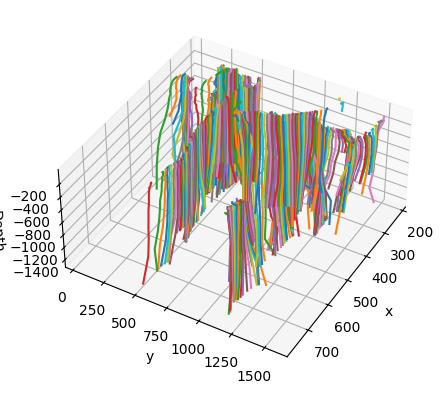

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for eddy in dic_sample:
    dic_eddy = dic_sample[eddy]
    for day in dic_eddy:
        df = dic_eddy[day]
        ax.plot(df['x'], df['y'], df['Depth'])

ax.view_init(elev=40, azim=30)
ax.set_box_aspect((1, 1, .5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Depth')

plt.show()


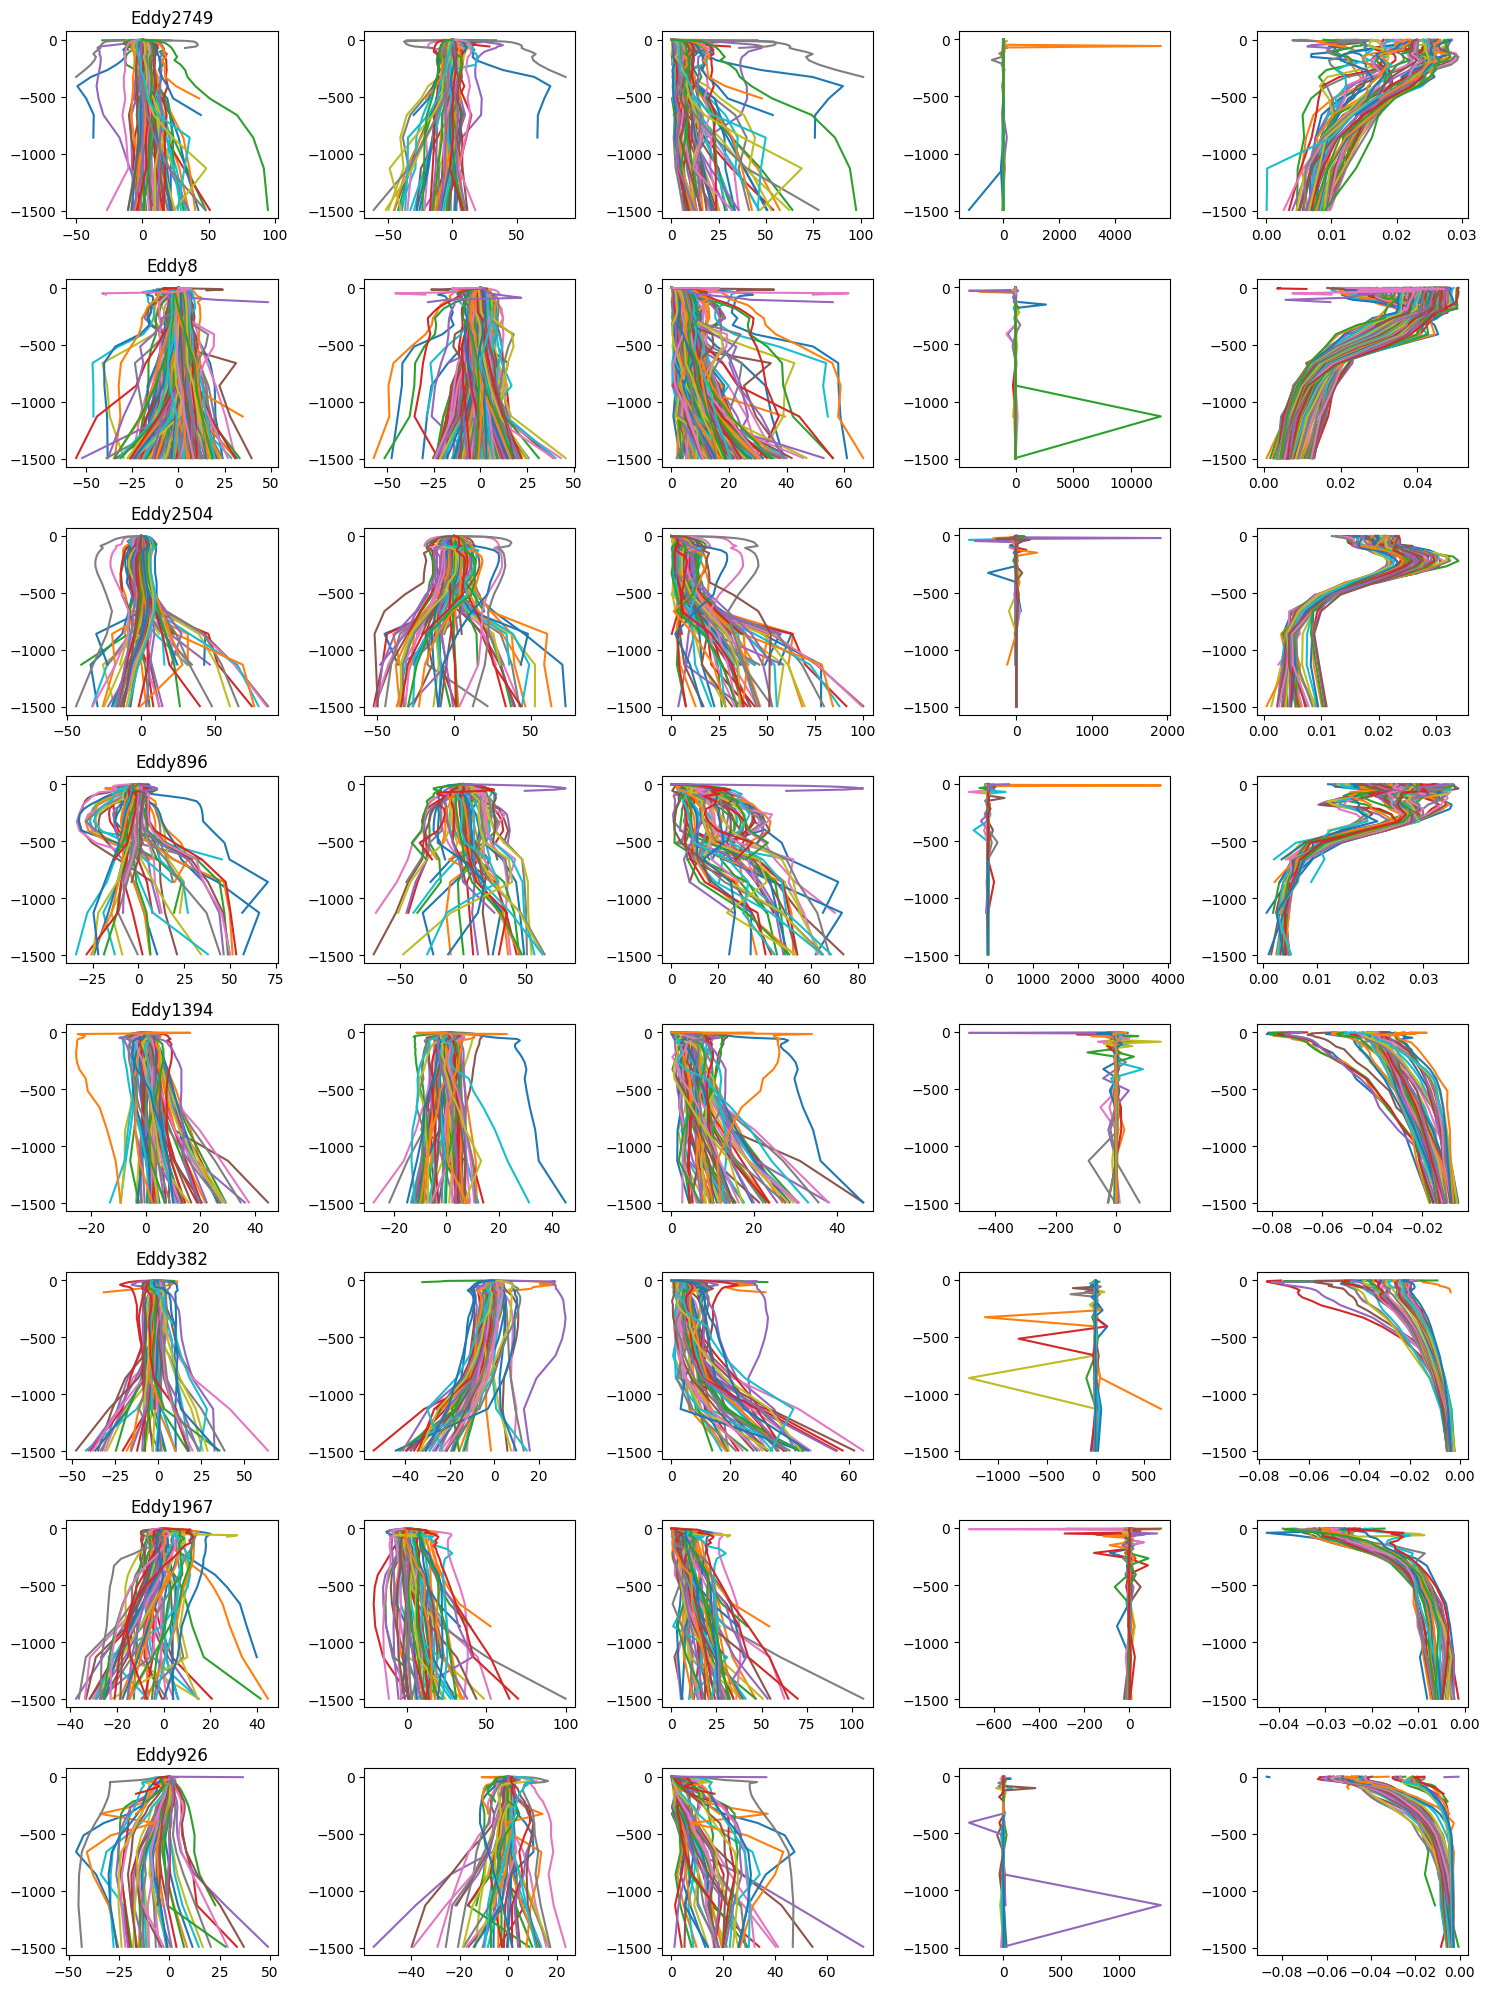

In [7]:
fig, axs = plt.subplots(8, 5, figsize=(15,20))

for e, eddy in enumerate(dic_sample):
    dic_eddy = dic_sample[eddy]
    for day in dic_eddy:
        df = dic_eddy[day]
        axs[e,0].plot(df['x']-df.iloc[0]['x'], df['Depth'])
        axs[e,1].plot(df['y']-df.iloc[0]['y'], df['Depth'])
        axs[e,2].plot(df['TD'], df['Depth'])
        axs[e,3].plot(df['Grad'], df['Depth'])
        axs[e,4].plot(df['w'], df['Depth'])
        axs[e,0].set_title(eddy)

plt.tight_layout()
plt.show()

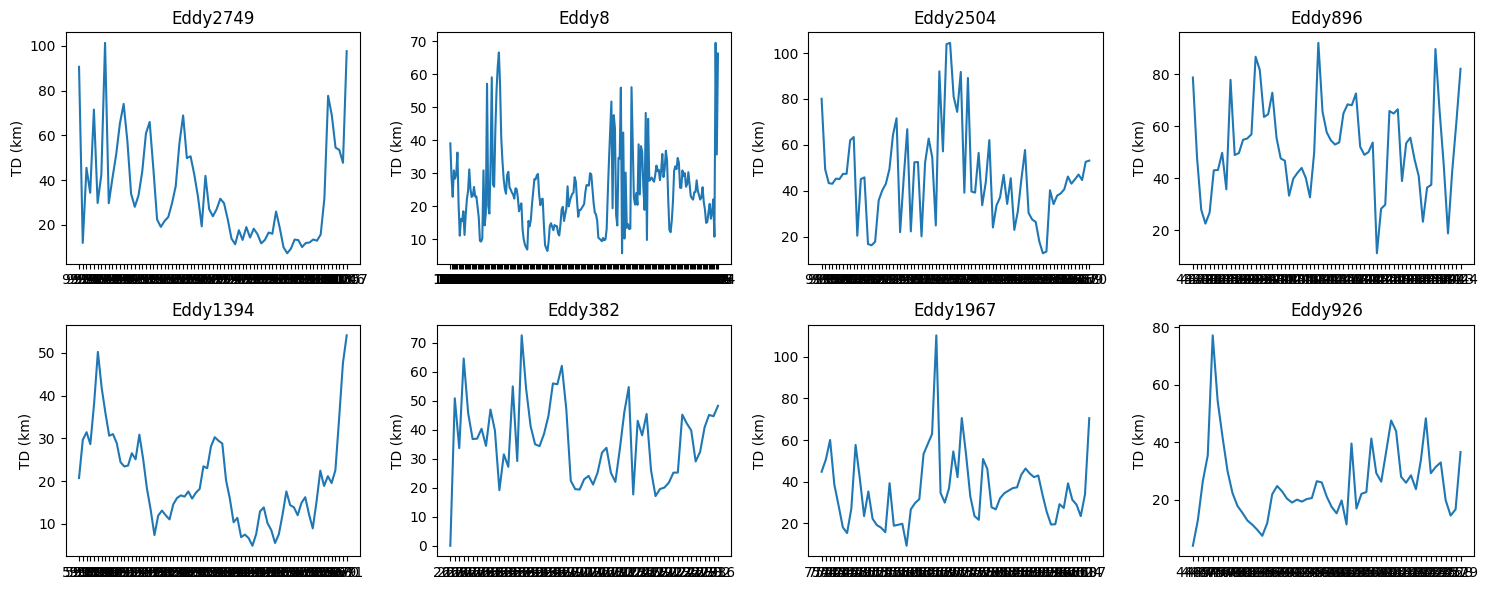

In [8]:
df_TD = pd.DataFrame(columns=['Eddy', 'Day', 'TD'])
for eddy in dic_sample:
    dic_eddy = dic_sample[eddy]
    for day in dic_eddy:
        df = dic_eddy[day]
        TD = np.hypot(df['x'].max()-df['x'].min(), df['y'].max()-df['y'].min())
        df_TD.loc[len(df_TD)] = {'Eddy': eddy[4:], 'Day': day[3:], 'TD': TD}

fig, axs = plt.subplots(2, 4, figsize=(15,6))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    
    df = df_TD[df_TD['Eddy']==str(eddy)]
    ax.plot(df['Day'], df['TD'])
    ax.set_title(f'Eddy{eddy}')
    ax.set_ylabel('TD (km)')
plt.tight_layout()
plt.show()


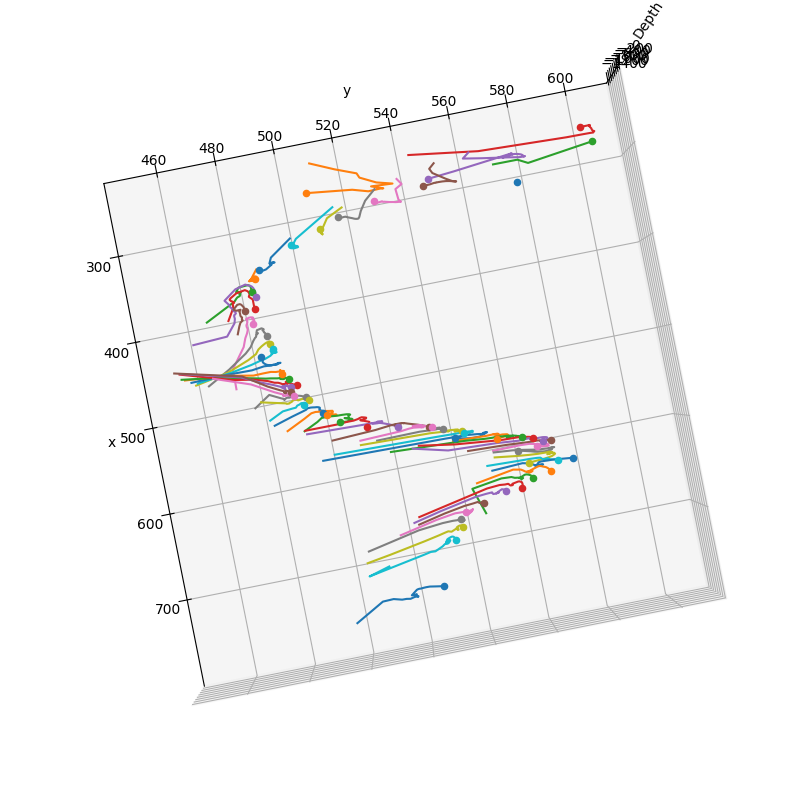

In [118]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for eddy in dic_sample:
    # if eddy in ['Eddy2749', 'Eddy2504']: Eddy896 Eddy382
    if eddy in ['Eddy382']:
        dic_eddy = dic_sample[eddy]
        for day in dic_eddy.keys():
            df = dic_eddy[day].copy()
            ax.scatter(df.iloc[0]['x'], df.iloc[0]['y'], df.iloc[0]['Depth'])
            ax.plot(df['x'], df['y'], df['Depth'])

ax.view_init(elev=90, azim=-15)
ax.set_box_aspect((1, 1, .5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Depth')

plt.show()


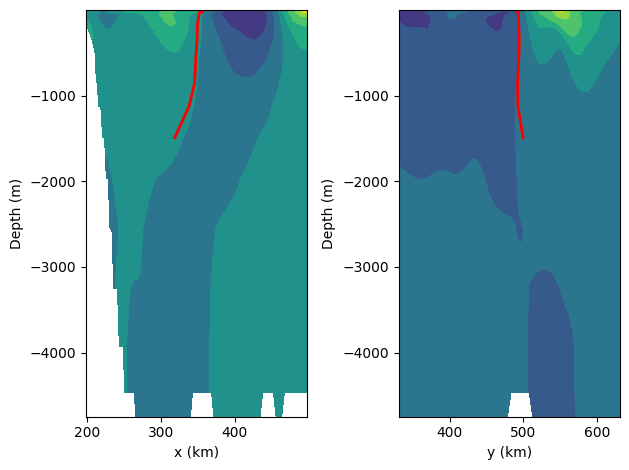

Day                                                   2683
ID                                                     382
Cyc                                                     CE
Lon                                             152.602952
Lat                                             -35.424778
ic                                                     134
jc                                                      98
x0                                              350.837184
y0                                              484.107488
q11                                              -0.005967
q12                                              -0.003104
q22                                              -0.010663
w                                                 -0.03326
Age                                                     69
fname    /srv/scratch/z3533156/26year_BRAN2020/outer_av...
Name: 248, dtype: object

In [69]:
df_sample = df_eddies[df_eddies['ID'].isin(sample_eddies)].reset_index(drop=True)

p = 248

data = df_sample.loc[p]
eddy, day, ic_surf, jc_surf, fname = data['ID'], data['Day'], data['ic'], data['jc'], data['fname']

fnumber = fname[-8:-3]

with nc.Dataset(fname) as dataset:
    ocean_time = dataset.variables['ocean_time'][:].data / 86400
t_rel = np.where(ocean_time == day)[0][0]

u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
u_raw = np.where(u_raw > 1e30, np.nan, u_raw).astype(float)
v_raw = np.where(v_raw > 1e30, np.nan, v_raw).astype(float)

u, v = u_raw[:,:,:,t_rel], v_raw[:,:,:,t_rel]

df = dic_sample[f'Eddy{eddy}'][f'Day{day}'].copy()

i_left, i_right, j_down, j_up = grid_finder(X_grid, Y_grid, ic_surf, jc_surf, 150)

q11s, q12s, q22s = [], [], []
for k in range(len(df)):
    Q = df.loc[k]['Q']
    q11s.append(Q[0,0])
    q12s.append(Q[0,1])
    q22s.append(Q[1,1])
df['q11'], df['q12'], df['q22'] = q11s, q12s, q22s
df = df.drop(columns=['Q'])

fig, axs = plt.subplots(1, 2)

axs[0].contourf(x_grid[ic_surf-i_left:ic_surf+i_right], z_r[150,150,:], v[ic_surf-i_left:ic_surf+i_right, jc_surf, :].T)
axs[0].plot(df['x'], df['Depth'], color='r', linewidth=2)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].contourf(y_grid[jc_surf-j_down:jc_surf+j_up], z_r[150,150,:], u[ic_surf, jc_surf-j_down:jc_surf+j_up, :].T)
axs[1].plot(df['y'], df['Depth'], color='r', linewidth=2)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()
data

In [161]:
df_sample.head()


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname,Top,Btm,R2
0,1462,8,AE,152.688281,-35.490215,137,97,360.411851,479.919772,0.007108,0.003003,0.006968,0.028152,233,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,"(3.053091920447116, -3.051461080959811, -0.001...","(27.39775244515363, -35.29609153616179, -1.492...",0.987319
1,1463,8,AE,152.679057,-35.601963,138,95,363.418874,467.973572,0.006676,0.001111,0.006341,0.026034,233,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,"(-2.1216186481546626, 5.906697885333532, -0.00...","(20.878804360772204, -16.831827307751812, -1.4...",0.976442
2,1464,8,AE,152.671726,-35.616015,138,95,363.266403,466.280808,0.007177,0.001652,0.006417,0.027189,233,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,"(-1.1741834888679206, 3.4509092314433785, -0.0...","(19.63566337704411, -9.853503759537698, -1.492...",0.959752
3,1465,8,AE,152.782992,-35.518158,140,97,369.511186,479.932130,0.005908,0.000886,0.005142,0.022100,233,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,"(-4.580364090460475, -3.005453345869447, -0.00...","(12.799679460341151, -24.658927861024512, -1.4...",0.922406
4,1466,8,AE,152.655353,-35.508451,136,97,358.199587,476.998993,0.005040,0.000989,0.005770,0.021620,233,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,"(3.3186315900504173, -2.919215681463905, -0.00...","(21.504398761668817, -18.507961490146023, -1.4...",0.932706


In [162]:
# Ensure required columns exist with correct dtype
for col in ['Top', 'Btm']:
    if col not in df_sample.columns or df_sample[col].dtype != 'object':
        df_sample[col] = pd.Series([np.nan] * len(df_sample), dtype=object)
if 'R2' not in df_sample.columns:
    df_sample['R2'] = np.nan

for eddy in sample_eddies:
    dic_eddy = dic_sample[f'Eddy{eddy}']
    
    for day, df in dic_eddy.items():
        df = df.copy()
        df[['x', 'y']] = df[['x', 'y']].astype(float)
        df[['x', 'y']] -= df.iloc[0][['x', 'y']]
        df['Depth'] = df['Depth'].astype(float) / 1000
        df['w'] = df['w'].astype(float)

        points = df[['x', 'y', 'Depth']].values.astype(float)
        weights = 1 / df['w'].values
        weights /= weights.sum()

        centroid = np.average(points, axis=0, weights=weights)
        centered = points - centroid
        cov = (centered * weights[:, None]).T @ centered
        cov = cov.astype(float)

        _, _, Vt = np.linalg.svd(cov)
        direction = Vt[0]

        proj = centroid + np.outer((points - centroid) @ direction, direction)
        ss_res = np.sum(weights * np.sum((points - proj) ** 2, axis=1))
        ss_tot = np.sum(weights * np.sum(centered ** 2, axis=1))
        r2 = 1 - ss_res / ss_tot

        z_line = np.linspace(df['Depth'].min(), df['Depth'].max(), 3)
        t = (z_line - centroid[2]) / direction[2]
        x_line = centroid[0] + t * direction[0]
        y_line = centroid[1] + t * direction[1]

        top_point = (x_line[-1], y_line[-1], z_line[-1])
        btm_point = (x_line[0], y_line[0], z_line[0])

        mask = (df_sample['ID'] == eddy) & (df_sample['Day'] == int(day[3:]))
        idx = df_sample.index[mask]

        if len(idx) == 1:
            df_sample.at[idx[0], 'Top'] = top_point
            df_sample.at[idx[0], 'Btm'] = btm_point
            df_sample.at[idx[0], 'R2'] = r2


/scratch/pbs.6495116.kman.restech.unsw.edu.au/ipykernel_3373914/3364668980.py:33: RuntimeWarning: invalid value encountered in scalar divide
  r2 = 1 - ss_res / ss_tot
/scratch/pbs.6495116.kman.restech.unsw.edu.au/ipykernel_3373914/3364668980.py:36: RuntimeWarning: invalid value encountered in divide
  t = (z_line - centroid[2]) / direction[2]


In [164]:
df

,x,y,Q,w,z,Depth,TD,Grad
0,0.000000,0.000000,"[[-0.0028173834668247916, -0.00204558167450195...",-0.022814,0,-0.001783,0.000000,NaN
1,-1.543231,-2.747057,"[[-0.0027520224522810163, -0.00208557985416690...",-0.021487,1,-0.005880,3.150855,1.780068
2,-2.444283,-4.342270,"[[-0.0027868000190987346, -0.00162406269224796...",-0.020535,2,-0.010726,4.982953,1.770389
3,-2.501060,-5.486083,"[[-0.002762533348038063, -0.001624422055073367...",-0.019976,3,-0.016383,6.029296,20.145673
4,-2.346335,-6.388769,"[[-0.002749131745155566, -0.001625180847809622...",-0.019415,4,-0.022926,6.806001,-5.834135
5,-2.044868,-7.197926,"[[-0.0027421409590647093, -0.00162671222458706...",-0.018685,5,-0.030444,7.482755,-2.684065
6,-2.083755,-7.766828,"[[-0.002749708118596256, -0.001152541495937151...",-0.018283,6,-0.039053,8.041496,14.629684
7,-1.868063,-8.164025,"[[-0.0027521676618959628, -0.00115490389124801...",-0.018079,7,-0.048898,8.375020,-1.841500
8,-1.378709,-8.589814,"[[-0.0027857023768235825, -0.00115960284445035...",-0.017956,8,-0.060171,8.699756,-0.870106
9,3.540531,-10.518158,"[[-0.0030334875400878773, -0.00137136355783269...",-0.018212,9,-0.073128,11.098063,-0.392000


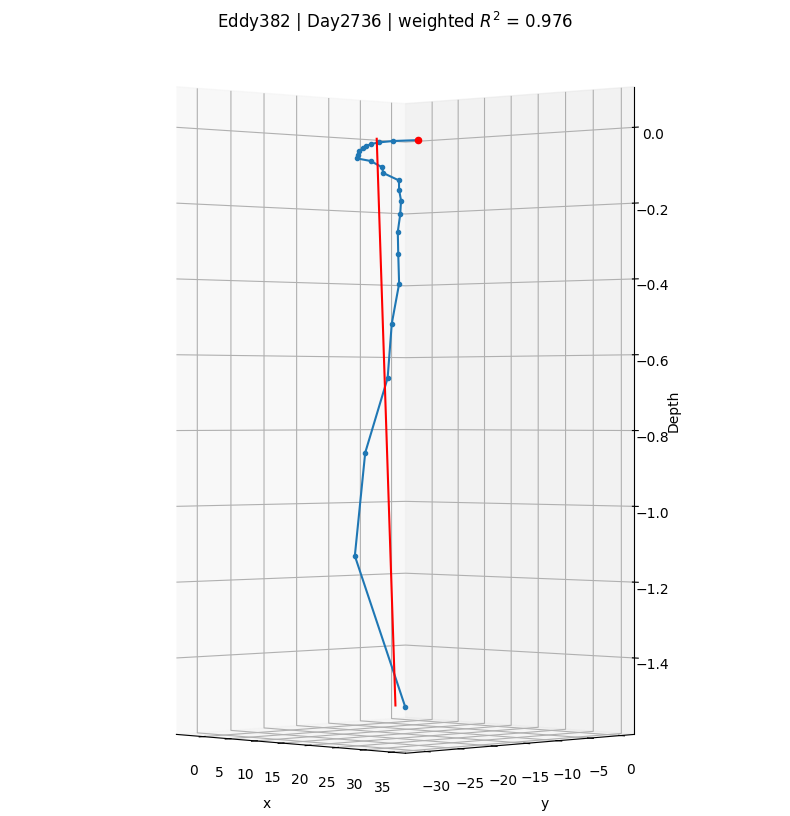

In [178]:
eddy = 'Eddy382'
t = 60

dic_eddy = dic_sample[eddy]

days = list(dic_eddy.keys())
day = days[t]
df = dic_eddy[day].copy()
df['x'] = df['x'] - df.iloc[0]['x']
df['y'] = df['y'] - df.iloc[0]['y']
df['Depth'] = df['Depth'] / 1000

df_line = df_sample[(df_sample['ID']==int(eddy[4:]))&(df_sample['Day']==int(day[3:]))]

top = df_line.iloc[0]['Top']
btm = df_line.iloc[0]['Btm']
r2 = df_line.iloc[0]['R2']

# 7. Plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.iloc[0]['x'], df.iloc[0]['y'], df.iloc[0]['Depth'], color='r')
ax.plot(df['x'], df['y'], df['Depth'], marker='.')
ax.plot([top[0], btm[0]], [top[1], btm[1]], [top[2], btm[2]], color='red')

ax.view_init(elev=0, azim=-45)
ax.set_box_aspect((1, 1, 2))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Depth')
ax.set_title(f'{eddy} | {day} | weighted $R^2$ = {r2:.3f}')
plt.show()


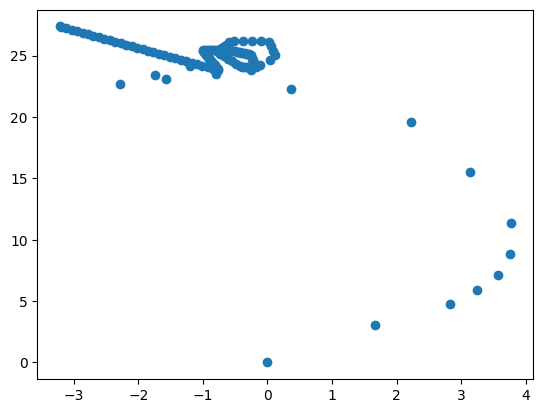

In [20]:
dic = dic_sample[f'Eddy{896}']
df = dic[list(dic.keys())[45]].copy()

interval = 5

dmin = (df.Depth.min() // interval) * interval
dmax = int(np.ceil(df.Depth.max() / interval)) * interval

# 2. build new Depth grid
new_depth = np.arange(dmin, dmax + interval, interval)

# 3. make sure your original is sorted by Depth and has no missing x,y
df_xy = df[['Depth','x','y']].dropna(subset=['x','y']).sort_values('Depth')
df_xy['x'] = df_xy['x'] - df_xy.iloc[-1]['x']
df_xy['y'] = df_xy['y'] - df_xy.iloc[-1]['y']

# 4. interpolate with numpy.interp
x_interp = np.interp(new_depth, df_xy.Depth, df_xy.x)
y_interp = np.interp(new_depth, df_xy.Depth, df_xy.y)

# 5. pack into a new DataFrame
df_interp = pd.DataFrame({
    'Depth': new_depth,
    'x': x_interp,
    'y': y_interp
})

plt.scatter(df_interp['x'], df_interp['y'])

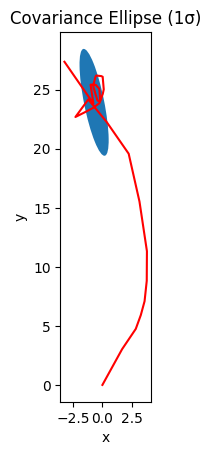

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math

pts = df_interp[['x', 'y']].dropna().values
center = pts.mean(axis=0)
cov = [[sum((pts[:,i]-center[i])*(pts[:,j]-center[j]))/(len(pts)-1)
        for j in range(2)] for i in range(2)]
# 2x2 covariance matrix

trace = cov[0][0] + cov[1][1]
det = cov[0][0]*cov[1][1] - cov[0][1]*cov[1][0]
term = ((trace**2)/4 - det)**0.5
lambda1 = trace/2 + term
lambda2 = trace/2 - term
eigenvec1 = [cov[0][1], lambda1 - cov[0][0]]
angle = (180/3.14159265) * (math.atan2(eigenvec1[1], eigenvec1[0]))
width, height = 2*(lambda1**0.5), 2*(lambda2**0.5)

fig, ax = plt.subplots()
ellipse = Ellipse(xy=center, width=width, height=height, angle=angle)
ax.add_patch(ellipse)
ax.plot(pts[:,0], pts[:,1], color='r')
ax.set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Covariance Ellipse (1σ)')
plt.show()


## Uplift attempt

In [28]:
df_w = df.copy()

df_w['x'] = df_w['x'] - df_w.iloc[0]['x']
df_w['y'] = df_w['y'] - df_w.iloc[0]['y']

x = np.linspace(df_w.x.min()-100, df_w.x.max()+100, 101)
y = np.linspace(df_w.y.min()-100, df_w.y.max()+100, 101)
X, Y = np.meshgrid(x, y)

U = np.zeros((X.shape[0], X.shape[1], len(df_w)))
V = np.zeros((X.shape[0], X.shape[1], len(df_w)))
for k, (x0, y0, q11, q12, q22) in enumerate(zip(df_w.x, df_w.y, df_w.q11, df_w.q12, df_w.q22)):
    U[:, :, k] = -2*q22*(Y-y0)-2*q12*(X-x0)
    V[:, :, k] = 2*q11*(X-x0)+2*q12*(Y-y0)


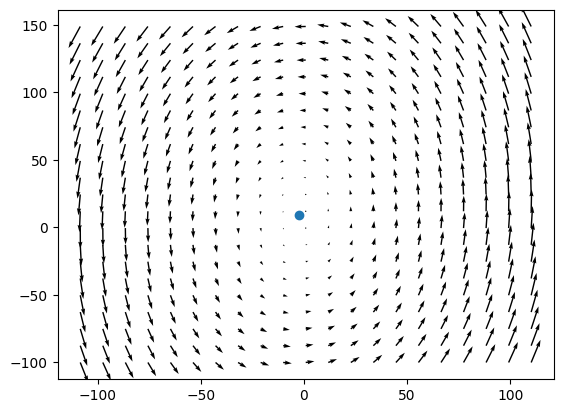

In [30]:
spacing = 5
k = 5
plt.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing], U[::spacing,::spacing,k], V[::spacing,::spacing,k])
x0, y0 = df_w.iloc[k]['x'], df_w.iloc[k]['y']
plt.scatter(x0, y0)


In [ ]:
break

## TRIAL AND ERROR 

# Governing Equation

We solve the PDE for vertical velocity $ w(x, y, z) $:

$$
f^2 \frac{\partial^2 w}{\partial z^2} + N^2 \left( \frac{\partial^2 w}{\partial x^2} + \frac{\partial^2 w}{\partial y^2} \right)
=
2f \frac{\partial}{\partial x} \left[ v_x u_z + v_y v_z - u_x u_z - u_y v_z \right]
$$

Define:

- $ u = u(x, y, z) $
- $ v = v(x, y, z) $
- $ x = x(x, y), y = y(x, y), z = z(k) $

We compute:

- First derivatives: $ u_x, u_y, u_z $, $ v_x, v_y, v_z $
- Then evaluate RHS:

$$
\text{RHS}(x,y,z) = 2f \cdot \frac{\partial}{\partial x} \left[ v_x u_z + v_y v_z - u_x u_z - u_y v_z \right]
$$

Then solve for $ w(x,y,z) $ from the full 3D PDE using finite differences.


In [ ]:
df.y.min()

In [ ]:
x = np.linspace(df.x.min(), df.x.max(), 101)*1000
y = np.linspace(df.y.min(), df.y.max(), 101)*1000

z = np.array(df['Depth'])

X, Y = np.meshgrid(x, y)

U = np.zeros((X.shape[0], X.shape[1], df['z'].max()+1))
V = np.zeros((X.shape[0], X.shape[1], df['z'].max()+1))

for k in range(len(df)):
    ddata = df.iloc[k]
    U[:,:,k] = -2*ddata.q22*(Y-ddata.y*1000)-2*ddata.q12*(X-ddata.x*1000)
    V[:,:,k] =  2*ddata.q11*(X-ddata.x*1000)+2*ddata.q12*(Y-ddata.y*1000)

k = 10

spacing = 5
plt.quiver(X[::spacing,::spacing], Y[::spacing,::spacing], U[::spacing,::spacing,k], V[::spacing,::spacing,k])
plt.axis('equal')

In [ ]:
import numpy as np

# --- assume you have ---
# U, V : numpy arrays of shape (nx, ny, nz)
# x, y : 1D numpy arrays of lengths nx and ny, respectively
# df['Depth'] gives your z‐levels (length nz)
# f, N : scalars

f = 7.3e-5
N = 5e-3
# grid dims
nx, ny, nz = U.shape

# horizontal spacings & coeffs
dx = x[1] - x[0]
dy = y[1] - y[0]
Ax = N**2 / dx**2
Ay = N**2 / dy**2

# vertical spacings & coeffs
h = np.diff(z)          # length nz-1
alpha  = np.zeros(nz)
for k in range(1, nz-1):
    hk, hkm1 = h[k], h[k-1]
    alpha[k] = 2.0/(hk+hkm1)
# build the per-layer denominators for the z-stencil
Azp = f**2 * alpha[1:-1] / h[1:]    # w[i,j,k+1] coefficient
Azm = f**2 * alpha[1:-1] / h[:-1]   # w[i,j,k-1] coefficient
den = 2*(Ax+Ay) + f**2*alpha[1:-1]*(1/h[1:]+1/h[:-1])

# reshape to broadcast over (i,j,k)
Azp3 = Azp[np.newaxis,np.newaxis,:]
Azm3 = Azm[np.newaxis,np.newaxis,:]
den3 = den[np.newaxis,np.newaxis,:]

# compute Ux, Uy, Uz, etc.
Ux, Uy, Uz = np.gradient(U, dx, dy, z, edge_order=2)
Vx, Vy, Vz = np.gradient(V, dx, dy, z, edge_order=2)
inner     = Vx*Uz + Vy*Vz - Ux*Uz - Uy*Vz
dinner_dx = np.gradient(inner, dx, axis=0, edge_order=2)
RHS       = 2*f * dinner_dx

# initialize
w     = np.zeros_like(U)
tol   = 1e-6
maxit = 2000

for it in range(maxit):
    w_old = w.copy()
    # single vectorised Jacobi update over all interior points:
    w[1:-1,1:-1,1:-1] = (
          Ax*(w_old[2:,1:-1,1:-1] + w_old[:-2,1:-1,1:-1])
        + Ay*(w_old[1:-1,2:,1:-1] + w_old[1:-1,:-2,1:-1])
        + Azp3 * w_old[1:-1,1:-1,2:]
        + Azm3 * w_old[1:-1,1:-1,:-2]
        + RHS[1:-1,1:-1,1:-1]
    ) / den3

    # check convergence
    diff = np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12)
    if diff < tol:
        print(f"Converged in {it} iters (rel change {diff:.2e})")
        break
else:
    print("Warning: max iterations reached, rel residual =", diff)

# now w contains your vertical velocity field much faster!


In [ ]:
depth_lvl = 5

plt.pcolor(X / 1000, Y / 1000, w[:, :, depth_lvl])
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title(f'w(x,y,z={z_dense[depth_lvl]:.1f} m)')
plt.colorbar(label='w')
plt.axis('equal')
plt.show()

## Mathematical Rundown: Solving for Vertical Velocity $ w(x, y, z) $

We are solving the following partial differential equation (PDE):

$$
f^2 \frac{\partial^2 w}{\partial z^2} + N^2 \left( \frac{\partial^2 w}{\partial x^2} + \frac{\partial^2 w}{\partial y^2} \right) =
8f \left[ q_{12}(z)\left(\frac{dq_{11}}{dz} - \frac{dq_{22}}{dz}\right) + \frac{dq_{12}}{dz}(q_{22}(z) - q_{11}(z)) \right]
$$

---

### Step 1: Separation of Variables

Assume a separable solution:

$$
w(x, y, z) = \phi(z) \cdot \psi(x, y)
$$

Substitute into the PDE:

$$
f^2 \phi''(z) \psi(x, y) + N^2 \phi(z) \nabla^2 \psi(x, y) = \text{RHS}(z)
$$

Divide through by $ \phi(z)\psi(x, y) $:

$$
\frac{f^2 \phi''(z)}{\phi(z)} + N^2 \frac{\nabla^2 \psi(x, y)}{\psi(x, y)} = \frac{\text{RHS}(z)}{\phi(z)\psi(x, y)}
$$

To isolate the $ z $-dependence, assume:

$$
\nabla^2 \psi = -k^2 \psi \quad \Rightarrow \quad \frac{\nabla^2 \psi}{\psi} = -k^2
$$

This yields an ODE for $ \phi(z) $:

$$
f^2 \phi''(z) - N^2 k^2 \phi(z) = \text{RHS}(z)
$$

Define:

$$
\lambda = \frac{N^2 k^2}{f^2}
\quad \Rightarrow \quad
\phi''(z) - \lambda \phi(z) = \frac{1}{f^2} \cdot \text{RHS}(z)
$$

---

### Step 2: Construct \( \text{RHS}(z) \)

From the input data:

$$
\text{RHS}(z) = 8f \left[ q_{12}(z) \left( \frac{dq_{11}}{dz} - \frac{dq_{22}}{dz} \right) + \frac{dq_{12}}{dz} \left( q_{22}(z) - q_{11}(z) \right) \right]
$$

The derivatives are computed numerically using finite differences.

---

### Step 3: Solve the ODE for \( \phi(z) \)

We solve:

$$
\phi''(z) - \lambda \phi(z) = \frac{\text{RHS}(z)}{f^2}
$$

with boundary conditions:

$$
\phi(z_{\text{min}}) = \phi(z_{\text{max}}) = 0
$$

This is done using `scipy.integrate.solve_bvp`.

---

### Step 4: Reconstruct the Full 3D Field

The final solution is:

$$
w(x, y, z) = \phi(z) \cdot \psi(x, y)
$$

with:

$$
\psi(x, y) = \sin(kx) \sin(ky)
$$

This gives a 3D vertical velocity field $ w $ on a grid over $ (x, y, z) $.





In [ ]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# Constants
f = 7.3e-5
N = 5e-3
k = 6.3e-5
Lam = (N**2 * k**2) / f**2

# Extract from DataFrame
z = df['z'].values
q11 = df['q11'].values
q12 = df['q12'].values
q22 = df['q22'].values

# Derivatives
dq11_dz = np.gradient(q11, z)
dq12_dz = np.gradient(q12, z)
dq22_dz = np.gradient(q22, z)

# RHS
RHS = 8 * f * (q12 * (dq11_dz - dq22_dz) + dq12_dz * (q22 - q11))
rhs_interp = lambda z_eval: np.interp(z_eval, z, RHS)

# ODE system for φ(z)
def odes(z, y):
    φ, φ_z = y
    return [φ_z, Lam * φ + rhs_interp(z) / f**2]

def bc(ya, yb):
    return [ya[0], yb[0]]

# Solve
z_dense = np.linspace(z.min(), z.max(), 100)
y_guess = np.zeros((2, len(z_dense)))
sol = solve_bvp(odes, bc, z_dense, y_guess)
φ_z = sol.sol(z_dense)[0]  # φ(z)

# Grid in x, y
Lx, Ly = 1e5, 1e5  # domain in metres
nx, ny = 100, 100
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# ψ(x, y) = sin(kx) sin(ky)
ψ = np.sin(k * X) * np.sin(k * Y)

# Construct w(x, y, z)
w = np.zeros((nx, ny, len(z_dense)))
for i, φ in enumerate(φ_z):
    w[:, :, i] = φ * ψ

# Plot example z slice

depth_lvl = 0

plt.contourf(X / 1000, Y / 1000, w[:, :, depth_lvl], levels=50)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title(f'w(x,y,z={z_dense[depth_lvl]:.1f} m)')
plt.colorbar(label='w')
plt.axis('equal')
plt.show()


### Reduction of the 3D PDE to a 1D ODE Along an Eddy Centerline

We start with the full anisotropic elliptic PDE governing the vertical velocity $w(x, y, z)$:

$$
N^2 \left( \frac{\partial^2 w}{\partial x^2} + \frac{\partial^2 w}{\partial y^2} \right) + f^2 \frac{\partial^2 w}{\partial z^2} = \text{RHS}(x, y, z)
$$

This equation accounts for stratification through the Brunt–Väisälä frequency $N$, and rotation through the Coriolis parameter $f$.

---

#### Assumption: Solution Along a 1D Eddy Centerline

We assume the solution is only evaluated along a 1D curve in space:

$$
\mathbf{r}(z) = \left( x(z),\ y(z),\ z \right)
$$

Along this path:
- The vertical velocity is only a function of depth: $w = w(z)$,
- So its partial derivatives in $x$ and $y$ vanish:
  $$
  \frac{\partial w}{\partial x} = \frac{\partial^2 w}{\partial x^2} = 0, \quad
  \frac{\partial w}{\partial y} = \frac{\partial^2 w}{\partial y^2} = 0
  $$

---

#### Resulting Simplified Equation

Substituting into the original PDE:

$$
f^2 \frac{d^2 w}{dz^2} = \text{RHS}(x, y, z)
\quad \Rightarrow \quad
\frac{d^2 w}{dz^2} = \frac{\text{RHS}(x, y, z)}{f^2} = \frac{\text{RHS}(z)}{f^2} 
$$

This is a **second-order ODE** in $z$, where $f$ is required but $N$ no longer appears.

---

### Right-Hand Side Expression Along the Eddy Centerline

The governing equation along the eddy centerline becomes:

$$
\frac{d^2 w}{dz^2} = \frac{1}{f^2} \cdot \text{RHS}(z)
$$

Where the RHS is defined by:

\begin{align}
\text{RHS}(z) =\ 8f \cdot \Bigg[ \,
&\left( q_{11,z} \cdot x(z) + q_{11} \cdot x_z(z) + q_{12,z} \cdot y(z) + q_{12} \cdot y_z(z) \right)
\left( q_{12,x} + q_{22,y} \right) \\
& - \left( q_{12,z} \cdot x(z) + q_{12} \cdot x_z(z) + q_{22,z} \cdot y(z) + q_{22} \cdot y_z(z) \right)
\left( q_{11,x} + q_{12,y} \right) \\
& + q_{12} \cdot (q_{11,z} - q_{22,z}) + q_{12,z} \cdot (q_{22} - q_{11}) \, \Bigg]
\end{align}

Even though $w = w(z)$, the forcing term on the right-hand side depends on the spatial location of the eddy core $(x(z), y(z), z)$, and contains spatial derivatives of $q_{ij}(x, y, z)$ fields evaluated along that trajectory.

---



In [ ]:
from scipy.integrate import cumulative_trapezoid
import numpy as np

# Extract vectors
z = df['z'].values
x = df['x'].values * 1000
y = df['y'].values * 1000
q11 = df['q11'].values
q12 = df['q12'].values
q22 = df['q22'].values

# First derivatives wrt z
dq11_dz = np.gradient(q11, z)
dq12_dz = np.gradient(q12, z)
dq22_dz = np.gradient(q22, z)
dx_dz = np.gradient(x, z)
dy_dz = np.gradient(y, z)

# Use chain rule to extract partials wrt x and y
def estimate_partials(dq_dz, dq_dz_label):
    """Estimate dq/dx and dq/dy using chain rule and known dx/dz, dy/dz"""
    # Set up a 2x2 system at each point:
    # dq_dz = dq_dx * dx_dz + dq_dy * dy_dz + dq_dz (we already have dq_dz total, so remove actual dz part to isolate dq_dx/dq_dy)
    # We'll assume dq_dz = dq_dx * dx_dz + dq_dy * dy_dz and solve for dq_dx, dq_dy via least squares
    dq_dx = np.empty_like(dq_dz)
    dq_dy = np.empty_like(dq_dz)
    for i in range(len(z)):
        A = np.array([[dx_dz[i], dy_dz[i]]])  # shape (1,2)
        b = dq_dz[i:i+1]  # shape (1,)
        sol, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
        dq_dx[i], dq_dy[i] = sol
    return dq_dx, dq_dy

q12_x, q12_y = estimate_partials(dq12_dz, 'q12')
q22_y = estimate_partials(dq22_dz, 'q22')[1]
q11_x = estimate_partials(dq11_dz, 'q11')[0]
q12_y_alt = estimate_partials(dq12_dz, 'q12')[1]

# f constant
f = 7.3e-5

# Full RHS expression now active
A = (dq11_dz * x + q11 * dx_dz + dq12_dz * y + q12 * dy_dz) * (q12_x + q22_y)
B = (dq12_dz * x + q12 * dx_dz + dq22_dz * y + q22 * dy_dz) * (q11_x + q12_y_alt)
C = q12 * (dq11_dz - dq22_dz) + dq12_dz * (q22 - q11)

RHS = 8 * f * (A - B + C)
RHS_reduced = RHS / f**2

# Integrate to get w(z)
w_prime = cumulative_trapezoid(RHS_reduced, z, initial=0)
w = cumulative_trapezoid(w_prime, z, initial=0)

df['uplift'] = w
df
